In [1]:
import pandas as pd
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from torchvision.models import resnet18
from glob import glob
import io
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn

In [2]:
for i in glob("./LPMS*"): print(i)

.\LPMS_E_0_0.00_20230215142031666_RAW.csv
.\LPMS_E_0_0.00_20230416140934461_RAW.csv
.\LPMS_E_0_0.00_20890608090450898_RAW.csv
.\LPMS_E_0_0.00_20890613171630709_RAW.csv
.\LPMS_E_0_0.00_20890613195022511_Header.csv
.\LPMS_E_0_0.00_20890613195022511_RAW.csv
.\LPMS_E_V101_MaxG_20230628203059888_RAW.csv


In [5]:
# 파일명
file_name666 = 'LPMS_E_0_0.00_20230215142031666_RAW.csv'
file_name461 = 'LPMS_E_0_0.00_20230416140934461_RAW.csv'
file_name898 = 'LPMS_E_0_0.00_20890608090450898_RAW.csv'
file_name709 = 'LPMS_E_0_0.00_20890613171630709_RAW.csv'
file_name511 = 'LPMS_E_0_0.00_20890613195022511_RAW.csv'
file_name888 = 'LPMS_E_V101_MaxG_20230628203059888_RAW.csv'
file = "erase_for_security"

# Daraframe형식으로 엑셀 파일 읽기
df = pd.read_csv(file)

# 데이터 프레임 출력
df

,Time,V-101,V-102,V-103,V-104,V-105,V-106,V-107,V-108,V-109,V-110,V-111,V-112,V-113,V-114,V-115,V-116,V-117,V-118
0,0.000000,0,0,0,0,0,0,0,0,0,0,0.069189,0.068188,0.066566,0.127983,0,0,0,0
1,0.000005,0,0,0,0,0,0,0,0,0,0,-0.082183,-0.025821,-0.076199,-0.087810,0,0,0,0
2,0.000010,0,0,0,0,0,0,0,0,0,0,0.095034,0.118375,0.104141,0.134325,0,0,0,0
3,0.000015,0,0,0,0,0,0,0,0,0,0,-0.046754,-0.056648,-0.002861,-0.075698,0,0,0,0
4,0.000020,0,0,0,0,0,0,0,0,0,0,0.071383,-0.008821,0.071931,0.085568,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,0.099980,0,0,0,0,0,0,0,0,0,0,0.115561,0.264382,0.020599,-0.105429,0,0,0,0
19997,0.099985,0,0,0,0,0,0,0,0,0,0,0.212693,0.188255,0.128961,0.073123,0,0,0,0
19998,0.099990,0,0,0,0,0,0,0,0,0,0,0.061655,-0.056362,-0.033045,-0.101185,0,0,0,0
19999,0.099995,0,0,0,0,0,0,0,0,0,0,0.175428,-0.093961,0.061584,0.154305,0,0,0,0


### 시간-주파수

(20000,)


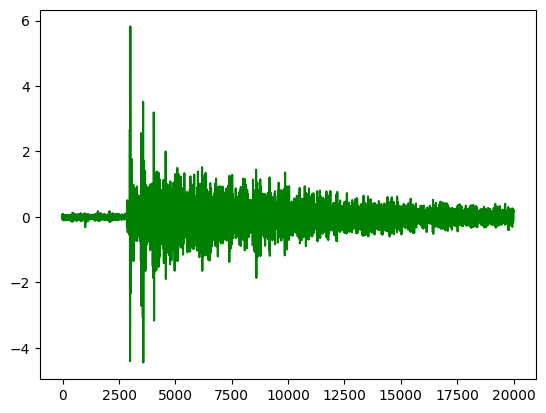

In [374]:
# 0.1sec 동안 20000개
N = 20000
dt = 0.000005
fs = N*10
FrameSize = 2000
nFFT = 128

# 데이터 보정 10을 곱해야 됨. (나중에 왜 이런식으로 데이터를 저장해놓았는지 여쭤보기)
l = 0
v101 = df['V-111'][:N]
print(v101.shape)
v101 = np.array(v101)

t = np.arange(N)
plt.plot(t, v101, color='green')

plt.show()

# FFT

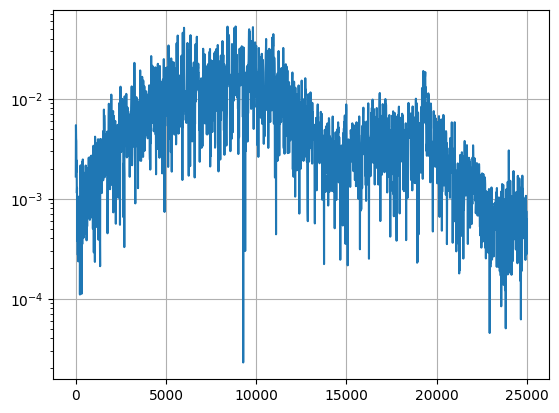

In [375]:
ub = 25000
yf = fft(v101)
xf = fftfreq(N, dt)[:N//2]
idx = np.where(xf == ub)[0].item()

plt.plot(xf[0:idx], 2.0/N * np.abs(yf[0:idx]))
plt.grid()
plt.yscale('log')
plt.show()

$x_k = \frac{k}{N*dt}$

In [376]:
y = 2.0/N * np.abs(yf[0:idx])
y.tofile("sample.bin")
y[0:20].dtype

dtype('float64')

# STFT

In [377]:
max_abs_idx = np.argmax(np.abs(v101))
start_idx = max_abs_idx - FrameSize//2
end_idx = max_abs_idx + FrameSize//2
if start_idx < 0:
    end_idx -= start_idx
    start_idx = 0
elif end_idx >= N:
    start_idx -= end_idx-(N-1)
    end_idx = N-1
if start_idx < 0: raise Exception("input data indexing error")
v101 = v101[start_idx: end_idx]

### input.txt로 저장

In [378]:
with open("input.txt", 'w') as f:
    f.write("42_3.587652378297776e-05.pth")
    f.write('\n')
    tmp = ",".join(map(str, v101))
    f.write(tmp)

In [379]:
win = signal.windows.hann(nFFT)

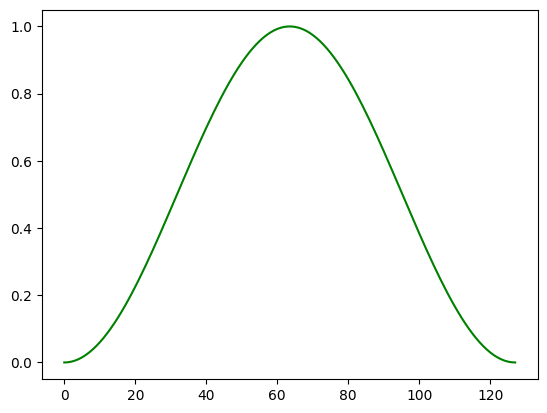

In [380]:
plt.plot(np.arange(nFFT), win, color='green')
plt.show()

In [381]:
# SFT = signal.ShortTimeFFT(win=win, hop=1, fs=fs, scale_to='psd', phase_shift=0)
SFT = signal.ShortTimeFFT(win=win, hop=1, fs=fs, scale_to='magnitude', phase_shift=0)
zData = SFT.stft(v101, p0=0, p1=FrameSize)
absZ = np.abs(zData)
print("zData: ", absZ.shape)

zData:  (65, 2000)


In [382]:
xData = np.arange(1, FrameSize+1)*SFT.delta_t
# yData = np.arange(1, nFFT+1)*SFT.delta_f
yData = SFT.f
y_ub = 25000
yData = yData[np.where(yData <= y_ub)]
absZ = absZ[:yData.shape[0], :]
print("xData : ", xData.shape)
print("yData : ", yData.shape)

xData :  (2000,)
yData :  (17,)


In [383]:
colorMax, colorMin = absZ.max(), absZ.min()
# Black #000000
# magenta #c20078
# Blue #0343df
# Cyan #00ffff
# Green #15b01a
# yellow #ffff14
# OrangeRed #fe420f
# Red #e50000
# White #ffffff
colors = ['#000000', '#c20078', '#0343df', '#00ffff', '#15b01a', '#ffff14', '#fe420f', '#e50000', '#ffffff']

norm = plt.Normalize(colorMin, colorMax)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

levels = [0, colorMin]
for i in range(1, 8): levels.append(colorMin + i * (colorMax - colorMin) / 9)
levels.append(colorMax)

colormapping = cm.ScalarMappable(norm=norm, cmap=cmap)
levels

[0,
 1.613877530584661e-05,
 0.13509086104117154,
 0.27016558330703727,
 0.40524030557290297,
 0.5403150278387686,
 0.6753897501046343,
 0.8104644723705,
 0.9455391946363657,
 1.2156886391680972]

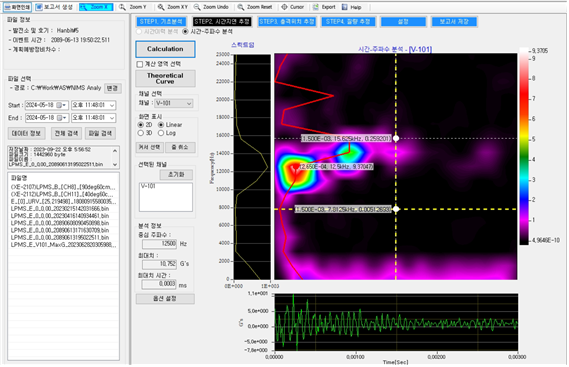

### 가운데 그래프

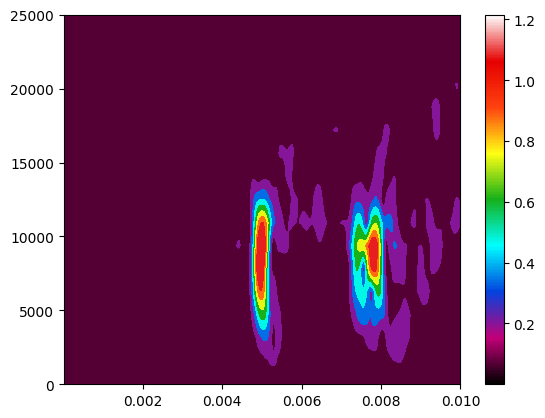

In [384]:
plt.ylim([0, 25000])
plt.colorbar(colormapping, ax=plt.gca())
plt.contourf(xData, yData, absZ, levels=levels, cmap=cmap, norm=norm)

### 왼쪽에 있는 그래프

In [385]:
xD = absZ.sum(axis=1)
xD.resize(nFFT)
yD = np.arange(1, nFFT+1)*SFT.delta_f
print("xD : ", xD.shape)
print("yD : ", yD.shape)
print(xD[:5])

xD :  (128,)
yD :  (128,)
[ 34.5666713716  73.7439575953 113.647868224  160.6340078673
 200.2663169921]


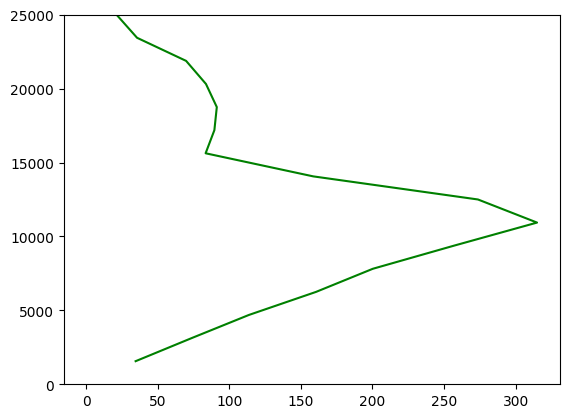

In [386]:
# plt.plot(yD, xD, color='green')
# plt.xlim([0, 25000])
# plt.show()
plt.plot(xD, yD, color='green')
plt.ylim([0, 25000])
plt.show()

### 아래에 있는 그래프

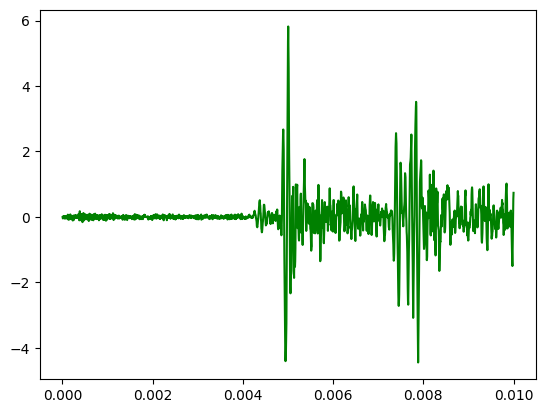

In [387]:
t = np.arange(1, FrameSize+1)*SFT.delta_t
plt.plot(t, v101, color='green')

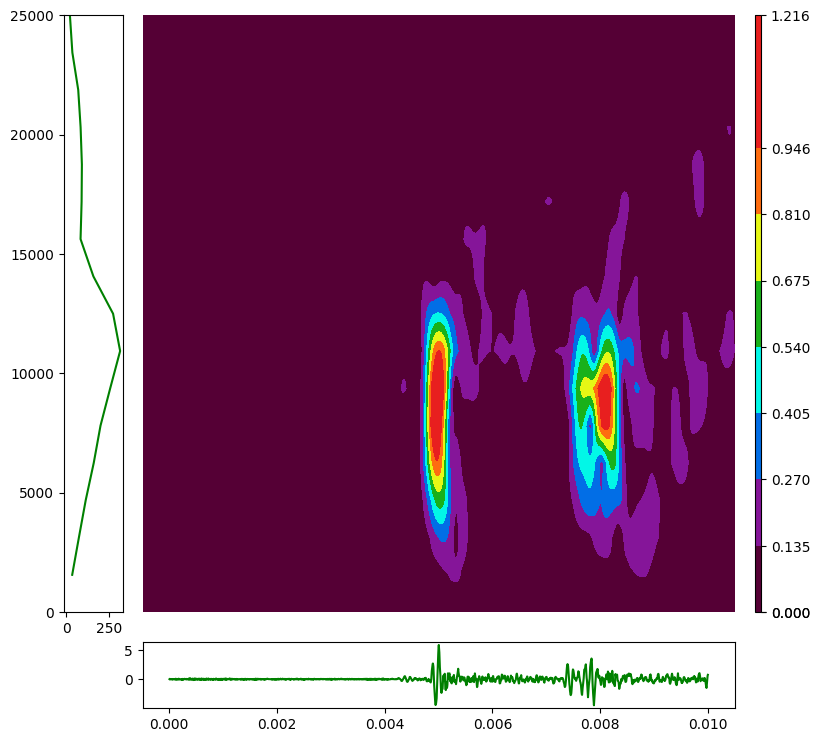

In [388]:
margin = 0.09
sz = 9
fig, ax = plt.subplots(
    2, 3, gridspec_kw={"width_ratios": [0.9, 9, 0.1], "height_ratios": [9, 1]}
)

ax[0,0].plot(xD, yD, color='green')
ax[0,0].set_ylim([0, 25000])

contour = ax[0,1].contourf(xData, yData, absZ, levels=levels, cmap=cmap, norm=norm)
ax[0,1].axis("off")
ax[0,1].set_ylim([0, 25000])

t = np.arange(1, FrameSize+1)*SFT.delta_t
ax[1,1].plot(t, v101, color='green')

fig.delaxes(ax[1,0])
fig.delaxes(ax[1,2])
fig.set_figheight(sz)
fig.set_figwidth(sz)

cbar = fig.colorbar(contour, cax=ax[0, 2], orientation='vertical', spacing='proportional')
plt.subplots_adjust(wspace=margin, hspace=margin)
plt.savefig("sample.png", dpi=400)

PIL.Image.Image

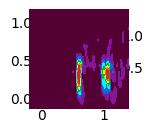

In [389]:
fig = plt.figure(frameon=False)
fig.set_size_inches(1, 1)
plt.colorbar(colormapping, ax=plt.gca())
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.contourf(xData, yData, absZ, levels=levels, cmap=cmap, norm=norm)
# 플롯을 이미지로 변환하지 않고 바로 토치 텐서로 변환
buf = io.BytesIO()  # 임시로 바이트 스트림을 생성하여 이미지를 저장하지 않고 변환
plt.savefig(buf, format='png')
buf.seek(0)
image = Image.open(buf).convert('RGB')
type(image)

In [390]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [391]:
image = transform(image)
# image = image.unsqueeze(0)
image.shape

torch.Size([3, 300, 300])

In [364]:
from torchvision.transforms.functional import to_pil_image

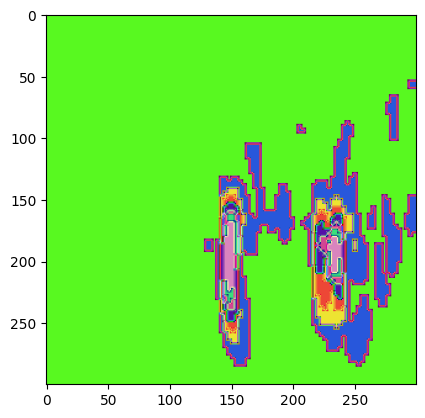

In [392]:
plt.imshow(to_pil_image(image))

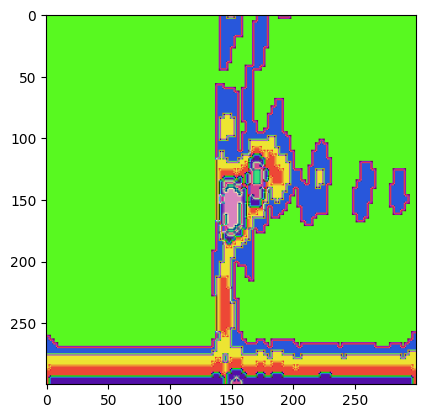

In [365]:
plt.imshow(to_pil_image(image))

In [366]:
model = resnet18()
num_classes = 1
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, num_classes), nn.Sigmoid())


weights_path = '42_3.587652378297776e-05.pth'

# Load weights into the model
model.load_state_dict(torch.load(weights_path, map_location='cpu'))

<All keys matched successfully>

In [367]:
image = image.unsqueeze(0)

In [368]:
model.eval()
with torch.no_grad():
    outputs = model(image)
    output = torch.round(outputs) == 1
torch.set_printoptions(sci_mode=False)
prob = outputs.item()
print(output.item(), f"{prob:.10f}")

False 0.0006790481
